__title__       = ML in Action Code:Chapter 3
__author__      = wgj(太阳老公)
__createDate__  = 2018-10-9
__description__ = Decision Tree 4 lenses


In [1]:
from math import log
import operator
import treePlotter

""" 计算香农熵 """
def calcShannonEnt(dataSet):  
    numEntries = len(dataSet) # 样本数量
    labelCounts = {}
    for featVec in dataSet:   # 逐行读取样本
        currentLabel = featVec[-1]  # 当前样本类别
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1  # 统计每种类别出现的次数，保存为字典
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries  # 每种类别出现的频率
        shannonEnt -= prob * log(prob,2)           # 按香农公式计算香农熵
    return shannonEnt

""" 分割数据集 """
def splitDataSet(dataSet, axis, value):
    retDataSet = []                 # 初始化分割后的样本集为空
    for featVec in dataSet:         # 逐行读取样本
        if featVec[axis] == value:  # axis代表选取的特征列索引，value代表特征的某一取值
            reducedFeatVec = featVec[:axis]     # 取出特征列左侧的数据
            reducedFeatVec.extend(featVec[axis+1:])  # 合并特征列右侧的数据
            retDataSet.append(reducedFeatVec)
            """
            返回值为一样本子集，样本数量（行数）与axis指向特征取值为value的样本子集（记为C）相同
            该样本子集是在上述样本子集C的基础上剔除掉axis指向特征取值为value的一列
            （exg：贷款申请样本集中，axis指向年龄，value代表青年，返回值即为包含青年的样本子集中
            剔除掉青年所在列后的样本集）
            """ 
    return retDataSet

""" 选择最佳分割特征 """
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      # 特征数量
    baseEntropy = calcShannonEnt(dataSet)  # 基础熵为样本集本身的香农熵
    bestInfoGain = 0.0; bestFeature = -1   # 初始化最大信息增益为0；最佳特征索引为-1
    for i in range(numFeatures):           # 遍历所有特征
        featList = [example[i] for example in dataSet] # 取出第i个特征列数据
        uniqueVals = set(featList)         # 第i个特征列的取值集合
        newEntropy = 0.0                   # 初始化当前特征香农熵为0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value) # 利用当前特征的每个取值分割样本集
            prob = len(subDataSet)/float(len(dataSet))   # 当前样本子集在全体样本集中的占比
            newEntropy += prob * calcShannonEnt(subDataSet) # 当前样本子集的香农熵
        infoGain = baseEntropy - newEntropy # 计算信息增益
        if (infoGain > bestInfoGain):       # 与历史最大信息增益比较
            bestInfoGain = infoGain         # 更新最大信息增益
            bestFeature = i                 # 更新最佳特征索引
    return bestFeature                      # 返回最佳特征列索引

""" 从类别列表中计算出现次数最多的类别 """
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

""" 构建决策树 """
def createTree(dataSet,labels):
    # labels为每个特征的名称/说明
    classList = [example[-1] for example in dataSet]    # 取出类别列
    if classList.count(classList[0]) == len(classList): # 只有1个类别时停止分割，返回当前类别
        return classList[0]  
    if len(dataSet[0]) == 1: # 当没有更多特征时停止分割，返回实例中数量最多的类
        return majorityCnt(classList)
    
    bestFeat = chooseBestFeatureToSplit(dataSet)  # 最佳特征对应的列号
    bestFeatLabel = labels[bestFeat]              # 最佳特征名称/说明
    myTree = {bestFeatLabel:{}}  # 嵌套创建树
    del(labels[bestFeat])        # 从特征名中删除掉已经选为最佳特征的
    featValues = [example[bestFeat] for example in dataSet]   # 最佳特征数据列
    uniqueVals = set(featValues) # 最佳特征列的取值集合
    for value in uniqueVals:
        subLabels = labels[:]    # 拷贝特征名，避免搞乱原有值
        """
        以下在以当前最佳特征为节点的下方递归构建树
        """
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

以下代码处理隐形眼镜问题

In [5]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses,lensesLabels)
lensesTree

{'tearRate': {'normal': {'astigmatic': {'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'presbyopic': 'no lenses',
        'young': 'hard',
        'pre': 'no lenses'}}}},
    'no': {'age': {'presbyopic': {'prescript': {'myope': 'no lenses',
        'hyper': 'soft'}},
      'young': 'soft',
      'pre': 'soft'}}}},
  'reduced': 'no lenses'}}

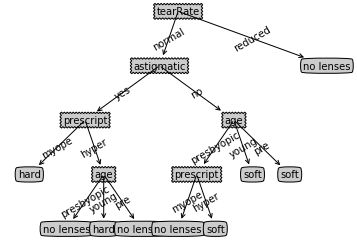

In [4]:
# 绘制决策树
treePlotter.createPlot(lensesTree)